<h1>1. Setup and Load Data</h1>

<h2>1.1. Install Dependencies and Setup</h2>

In [1]:
import tensorflow as tf
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
#Avoid OOM errorby setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

<h2>1.2. Load data</h2>

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
#Define paths to directory
data_dir = 'data'
train_data_dir = os.path.join(data_dir, 'Train')
val_data_dir = os.path.join(data_dir, 'Validation')
test_data_dir = os.path.join(data_dir, 'Test')

In [5]:
#Define hyperparameters
epochs = 35
batch_size = 16
image_size = (100, 100, 3)
learning_rate = 0.0001

In [6]:
#Data augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True
)

val_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [7]:
#Load training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = [100, 100],
    batch_size = batch_size,
    class_mode = 'binary',
    classes = ['real']
)

Found 70001 images belonging to 1 classes.


In [8]:
batch = train_generator.next()
batch[0].shape

(16, 100, 100, 3)

In [9]:
#Load validation data
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=[100, 100],
    batch_size=batch_size,
    class_mode='binary',
    classes = ['real']
)

Found 19787 images belonging to 1 classes.


In [10]:
#Load testing data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=[100, 100],
    batch_size=batch_size,
    class_mode='binary',
    classes = ['real', 'fake'],
    shuffle=False
)

Found 10905 images belonging to 2 classes.


<h1>2. Deep Model</h1>

<h2>2.1. Define Encoder, Decoder and Latent Encoder functions</h2>

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [12]:
#Define encoder
def encoder(inputs):
    x = inputs

  # Use 3 filters for RGB images
  x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.2)(x)  # Add dropout for regularization
  x = tf.keras.layers.MaxPooling2D((2, 2))(x)
  x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.2)(x)  # Add dropout
  x = tf.keras.layers.MaxPooling2D((2, 2))(x)
  x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.2)(x)  # Add dropout
  x = tf.keras.layers.MaxPooling2D((2, 2))(x)
  x = tf.keras.layers.Flatten()(x)

  # Reduce dimensionality for latent representation (adjust latent_dim as needed)
  latent_dim = 256
  z_mean = tf.keras.layers.Dense(latent_dim)(x)
  z_log_var = tf.keras.layers.Dense(latent_dim)(x)
    
  return z_mean, z_log_var

In [13]:
def reparameterize(mean, log_var):
    epsilon = tf.random.normal(tf.shape(mean))  # Sample random noise from a normal distribution
    stddev = tf.exp(0.5 * log_var)  # Calculate the standard deviation from the log variance
    sampled_z = mean + epsilon * stddev  # Reparameterization trick
    return sampled_z

In [14]:
def decoder(latent):
    x = latent

    # Increase dimensionality
    x = tf.keras.layers.Dense(1875, activation='relu')(x)
    x = tf.keras.layers.Reshape((25, 25, 3))(x)

    # Deconvolutional layers to upsample the image
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)  # Add dropout
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)  # Add dropout
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    # Final convolutional layer to generate the output image
    x = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    return x

In [15]:
def latent_encoder(latent):
    x = latent

    # Use a simpler architecture to focus on learning real face features
    x = tf.keras.layers.Dense(256, activation='relu')(x)  # Adjust the output dimension
    x = tf.keras.layers.Dropout(0.2)(x)  # Optional dropout layer
    x = tf.keras.layers.Dense(256, activation='relu')(x)  # Adjust the output dimension
    
    return x


In [16]:
x = tf.keras.Input(shape = image_size)

z_mean, z_log_var = encoder(x)

z = reparameterize(z_mean, z_log_var)

x_recon = decoder(z)

z_recon = latent_encoder(z)

In [17]:
# Reconstruction loss
reconstruction_loss = tf.reduce_mean(tf.square(x - x_recon))

#Latent space loss
latent_space_loss = tf.reduce_mean(tf.square(z - z_recon))
    
# Regularization term (KL divergence)
kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    
# Total loss
lambda_rec = 1.0
lambda_latent = 0.3
total_loss = lambda_rec * reconstruction_loss + kl_loss + lambda_latent * latent_space_loss

In [18]:
vae = tf.keras.Model(inputs=x, outputs=[x_recon, z_recon])
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 100, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [19]:
vae.add_loss(total_loss)
vae.compile(optimizer= Adam(learning_rate= learning_rate))

In [20]:
def train_model(model, train_generator, val_generator, epochs, initial_epoch, checkpoint_dir):
    
    # Check if checkpoint directory exists, create one if not
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # Define checkpoint path
    checkpoint_path = os.path.join(checkpoint_dir, "checkpoint")

    # Create a callback to save model weights
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        save_best_only=False,  # Save weights for every epoch
        verbose=1
    )

    # Load weights from the latest checkpoint if available
    if os.path.exists(checkpoint_path):
        model.load_weights(checkpoint_path)
        print("Resuming training from epoch", initial_epoch + 1)

    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        initial_epoch=initial_epoch,
        validation_data=val_generator,
        callbacks=[checkpoint_callback] # Add more callbacks if needed
    )

    # Access training and validation loss histories
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    return history, train_loss, val_loss

initial_epoch = 34
history, train_loss, val_loss = train_model(vae, train_generator, val_generator, epochs=epochs, initial_epoch=initial_epoch, checkpoint_dir="checkpoints")


Resuming training from epoch 35
Epoch 35/35
4376/4376 [==============================] - ETA: 0s - loss: 0.2325
Epoch 35: saving model to checkpoints\checkpoint
4376/4376 [==============================] - 225s 50ms/step - loss: 0.2325 - val_loss: 0.2260


In [21]:
# Assuming train_loss and val_loss are lists containing the loss values
print("Training Loss:")
for loss in train_loss:
    print(loss)

print("\nValidation Loss:")
for loss in val_loss:
    print(loss)

Training Loss:
0.2324676662683487

Validation Loss:
0.22601453959941864


In [ ]:
# Initialize lists to store loss values
real_losses = []
fake_losses = []

for i in range(len(test_generator)):
    images, labels = test_generator[i]
    for j in range(len(images)):
        image = images[j:j+1]  # Take one image at a time
        label = labels[j]
        losses = vae.evaluate(image)
        if label == 0:  # Check the label of the current image
            real_losses.append(losses)
        else:
            fake_losses.append(losses)

1/1 [==============================] - ETA: 0s - loss: 0.2883

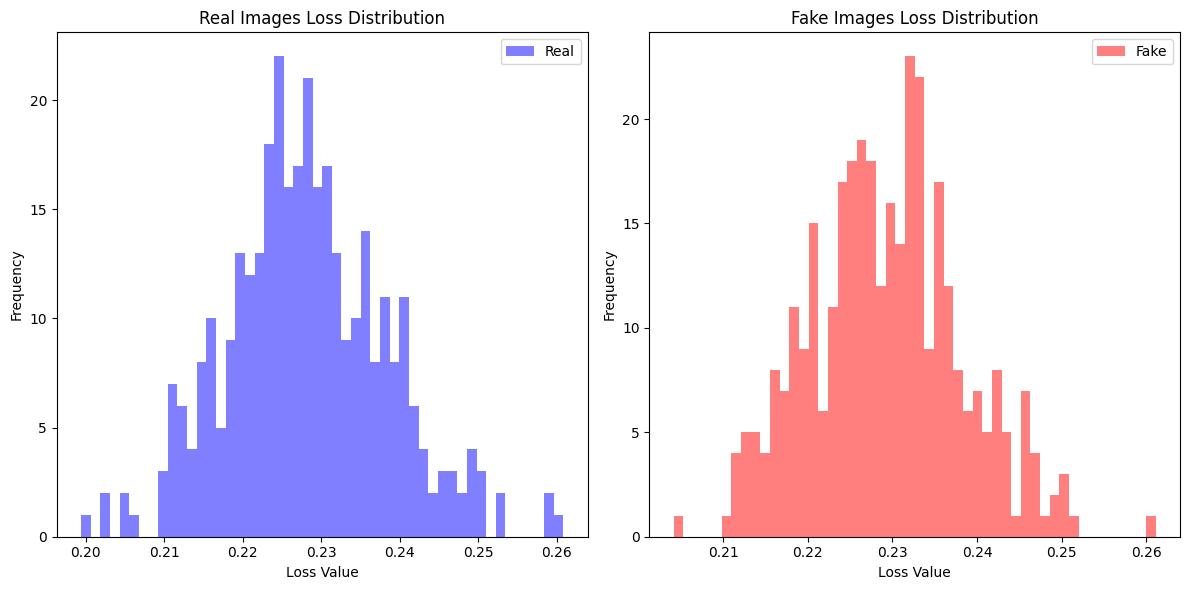

In [27]:
# Create separate plots for real and fake losses
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(real_losses, bins=50, alpha=0.5, color='blue', label='Real')
plt.title('Real Images Loss Distribution')
plt.xlabel('Loss Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.hist(fake_losses, bins=50, alpha=0.5, color='red', label='Fake')
plt.title('Fake Images Loss Distribution')
plt.xlabel('Loss Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [71]:
# Calculate mean and standard deviation for each distribution
mean_real_loss = np.mean(real_losses)
std_real_loss = np.std(real_losses)

mean_fake_loss = np.mean(fake_losses)
std_fake_loss = np.std(fake_losses)

# Choose a threshold (e.g., mean + 2*std)
threshold = mean_real_loss + 2.5 * std_real_loss

print("Threshold value:", threshold)

Threshold value: 0.2536133849295963


In [72]:
from tensorflow.keras.models import load_model
vae.save(os.path.join('models', 'deepfake_detection_complete_OC-VAE_model.h5'))

In [73]:
import cv2

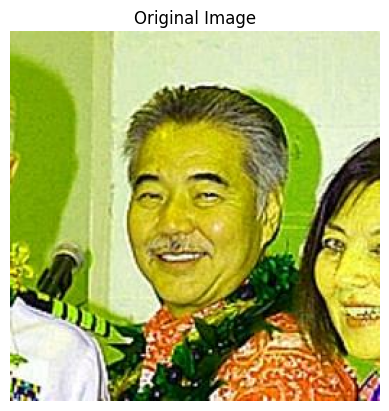

In [77]:
# Load the image using OpenCV
img = cv2.imread('real_2368.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Display the original image
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.show()

In [78]:
img = tf.image.resize(img, (100, 100))  # Resize to (100, 100)
img = img / 255.0  # Normalize pixel values to [0, 1]

# Add batch dimension to match model's input shape
img= tf.expand_dims(img, axis=0)

# Verify the shape
print("Shape of input image batch:", img.shape)

# Pass the input data to the model
output = vae(img_batch)

Shape of input image batch: (1, 100, 100, 3)


In [79]:
# Calculate reconstruction loss
reconstruction_loss = vae.evaluate(img)

# Compare reconstruction loss with threshold
if reconstruction_loss > threshold:
    print("The image is classified as a deepfake.")
else:
    print("The image is classified as real.")

1/1 [==============================] - 0s 34ms/step - loss: 0.3001
The image is classified as a deepfake.
